In [ ]:
#load the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
#set the constants
image_size = 256
batch_size = 32
epochs = 30
channels = 3


In [ ]:
# Clear previous mount point if it exists
import shutil
shutil.rmtree('/content/drive', ignore_errors=True)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#load the images into a tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "/content/drive/MyDrive/ColabNotebooks/PlantVillage",
            seed=100,
            image_size = (image_size,image_size),
            batch_size = batch_size,
            shuffle = True)

Found 2162 files belonging to 6 classes.


In [ ]:
#for i in dataset.take(1).as_numpy_iterator():
#    print(i)

In [ ]:
#get the 3 class names, i.e the folder names
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'models',
 'models ',
 'p_models']

In [ ]:
len(dataset)

68

In [ ]:
#the length of dataset is 68, because each element takes a batch size of 32 images
68*32

2176

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 2 0 1 0 2 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 2 0 1 1 1 0]


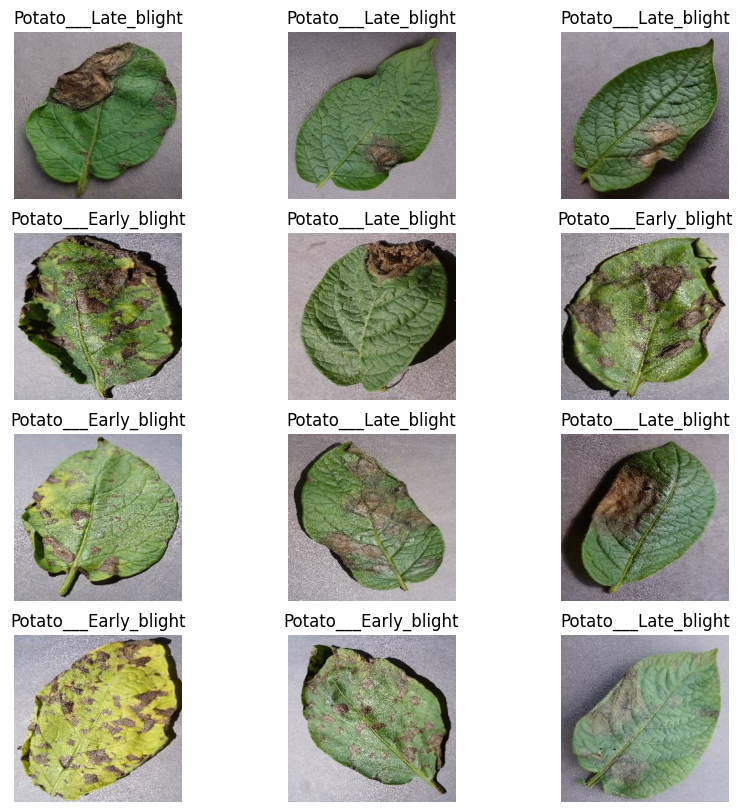

In [ ]:
#visulaize the images
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        axis = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis('off')

In [ ]:
#split the dataset into train,validation and test
train_size = len(dataset)*0.8
train_size

54.400000000000006

In [ ]:
train_df = dataset.take(54)
len(train_df)

54

In [ ]:
test_df = dataset.skip(54)
len(test_df)

14

In [ ]:
#use 10% of the dataset for validation
val_size = 0.1*len(dataset)
val_size

6.800000000000001

In [ ]:
#validation dataset would require taking the first 6
val_df = dataset.take(6)
len(val_df)

6

In [ ]:
#new test_df
test_df = test_df.skip(6)
len(test_df)

8

In [ ]:
#combine the lines of code above into a python function

def get_dataset_segments(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1
    data_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=10)

    train_size = int(train_split*data_size)
    val_size = int(val_split*data_size)

    train_df = dataset.take(train_size)
    val_df = dataset.skip(train_size).take(val_size)
    test_df = dataset.skip(train_size).skip(val_size)


    return train_df,val_df,test_df

In [ ]:
train_df,val_df,test_df = get_dataset_segments(dataset)

In [ ]:
len(train_df),len(test_df),len(val_df)

(54, 8, 6)

In [ ]:
#cache and prefetch
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#build a layer to resize and rescale the images

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1.0/255)
])

In [ ]:
#in order to improve accuracy of the model, we can perfrom data augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)
])

In [ ]:
#apply data augmentation to train dataset
train_df = train_df.map(lambda x,y: (data_augmentation(x , training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#build the cnn model

input_shape = (image_size,image_size,channels)
num_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.build(input_shape=(None,image_size,image_size,channels))

In [ ]:
#print summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#compile model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [ ]:
frame = model.fit(train_df,epochs=epochs,validation_data=val_df,batch_size=batch_size,verbose=1)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 398s 494ms/step - accuracy: 0.4311 - loss: 0.9631 - val_accuracy: 0.4531 - val_loss: 0.8743
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.5748 - loss: 0.8713 - val_accuracy: 0.7396 - val_loss: 0.6076
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.7111 - loss: 0.5827 - val_accuracy: 0.8906 - val_loss: 0.2685
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8489 - loss: 0.3843 - val_accuracy: 0.9271 - val_loss: 0.1838
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.8941 - loss: 0.2702 - val_accuracy: 0.8854 - val_loss: 0.2150
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9176 - loss: 0.2167 - val_accuracy: 0.9010 - val_loss: 0.2558
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.9158 - loss: 0.2006 - val_accuracy: 0.8490 - val_loss: 0.4570
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.9381 - loss: 0.1541 - val_acc

In [ ]:
scores = model.evaluate(test_df)
scores

In [ ]:
frame.params

In [ ]:
frame.history.keys()

In [ ]:
accuracy = frame.history['accuracy']
val_accuracy = frame.history['val_accuracy']

loss = frame.history['loss']
val_loss = frame.history['val_loss']

In [ ]:
#plot a graph of these metrics

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")



In [ ]:
#run prediction on sampe image

import numpy as np
for image_batch, label_batch in test_df.take(1):
  image_batch = image_batch[0].numpy().astype('uint8')
  label_batch = label_batch[0].numpy()

  print("First predicted image")
  print("Actual label:",class_names[label_batch])
  plt.imshow(image_batch)
  #add a batch dimension by using np.expand_dims()
  image_batch_with_dim = np.expand_dims(image_batch, 0)
  prediction_batch = model.predict(image_batch_with_dim)
  print("Predicted label:", class_names[np.argmax(prediction_batch[0])])

In [ ]:
#Write a function for inference

def predict(model, image):
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  image_array = tf.expand_dims(image_array, 0)
  prediction_label = class_names[np.argmax(model.predict(image_array))]
  confidence = round(100 * np.max(model.predict(image_array)),2)

  return prediction_label, confidence


In [ ]:
#run an inference on 12 image samples
plt.figure(figsize=(20,15))
for image_batch, label_batch in test_df.take(1):
  for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    prediction_label, confidence = predict(model, image_batch[i].numpy())
    plt.title(f"Prediction Label: {prediction_label},\nActual Label: {class_names[label_batch[i]]}\confidence: {confidence}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import joblib

model_dir = "/content/drive/MyDrive/ColabNotebooks/PlantVillage/p_models"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_versions = [int(i.split('.')[0]) for i in os.listdir(model_dir) if i.split('.')[0].isdigit()] + [0]
model_version = max(model_versions) + 1
joblib.dump(model, os.path.join(model_dir,f"{model_version}.pkl"))


['/content/drive/MyDrive/ColabNotebooks/PlantVillage/p_models/8.pkl']

In [ ]:
import os

model_dir = "/content/drive/MyDrive/ColabNotebooks/PlantVillage/p_models"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_versions = [int(i.split('.')[0]) for i in os.listdir(model_dir) if i.split('.')[0].isdigit()] + [0]
model_version = max(model_versions) + 1
model.save(os.path.join(model_dir,f"{model_version}.keras"))


In [ ]:
import os

model_dir = "/content/drive/MyDrive/ColabNotebooks/PlantVillage/models"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_versions = [int(i.split('.')[0]) for i in os.listdir(model_dir) if i.split('.')[0].isdigit()] + [0]
model_version = max(model_versions) + 1
model.save(os.path.join(model_dir,f"{model_version}.keras"))


In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
import os
print(os.path.exists(r"C:\Users\HP\potato disease\saved_models\4.keras"))  # Should return True if the file exists


False


In [ ]:


# Change this path according to your saved model format
model_path = r"C:\Users\HP\potato disease\saved_models\4.keras"  # Use .keras if saved in that format

# Load the model
try:
    MODEL = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")


Error loading model: File not found: filepath=C:\Users\HP\potato disease\saved_models\4.keras. Please ensure the file is an accessible `.keras` zip file.
